# Document Similarities Using Doc2Vec

Applying *leave One out*.

Based on this [doc](https://radimrehurek.com/gensim/models/doc2vec.html).

_______________________

In [3]:
!pip3 install gensim==4.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import gensim

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import re
from glob import glob

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
sns.set(font_scale = 1.2)
sns.set_style('white')
custom_palette = [sns.color_palette("colorblind", 11)[10], sns.color_palette("colorblind", 14)[13]]
sns.set_palette(palette = custom_palette)

plt.rcParams.update({'font.size': 22})

Importing corpus:

In [6]:
fiction_texts = []
others_texts = []


for filename in tqdm(glob('/content/drive/My Drive/PGCCMC/Projects/3. Mesoscopic/fiction/*.txt')):
    with open(filename, encoding="utf8", errors='ignore') as f:
        fiction_texts.append([f.read().replace('\n', ' '), 0])

for filename in tqdm(glob('/content/drive/My Drive/PGCCMC/Projects/3. Mesoscopic/others/*.txt')):
    with open(filename, encoding="utf8", errors='ignore') as f:
        others_texts.append([f.read().replace('\n', ' '), 1])

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Saving it into a dataframe:

In [7]:
documents_df = pd.DataFrame(fiction_texts + others_texts, columns = ['documents', 'class'])

documents_df.head(len(fiction_texts) + len(others_texts))

,documents,class
0,the Online Distributed Proofreading Team. ...,0
1,Note: Project Gutenberg also has an HTML versi...,0
2,https://www.pgdp.net (This file was produced f...,0
3,SALUTE TO ADVENTURERS. BY. JOHN BUCHAN. [I...,0
4,Proofreading Team at https://www.pgdp.net (Thi...,0
...,...,...
295,RAMBLES IN WOMAN...,1
296,Online Distributed Proofreading Team at http:/...,1
297,and PG Distributed Proofreaders. [Illustratio...,1
298,book was created from images of public domain ...,1


Removing special characters and stopwords from the text:

In [8]:
stop_words_l = stopwords.words('english')
documents_df['documents_cleaned'] = documents_df.documents.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l))
documents_df['documents_cleaned'] = documents_df['documents_cleaned'].apply(nltk.word_tokenize)

Applying shuffle:

In [9]:
documents_df = documents_df.sample(frac = 1).reset_index(drop = True)

documents_df

,documents,class,documents_cleaned
0,CHAPTER ONE. THE BEGINNING--IN WHICH SEVERAL ...,0,"[chapter, one, beginning, in, several, importa..."
1,"{Transcriber's Note: British, archaic and inco...",1,"[transcriber, s, note, british, archaic, incon..."
2,"[Illustration: ""'TO ALL INTENTS AND PURPOSES I...",0,"[illustration, to, intents, purposes, rich, ma..."
3,Copyright (C) 2003 by Robert J. Evans. Xlibri...,0,"[copyright, c, robert, j, evans, xlibris, publ..."
4,and the Online Distributed Proofreading Team (...,0,"[online, distributed, proofreading, team, http..."
...,...,...,...
295,"THE FOURTH ""R"". By G...",0,"[fourth, r, george, o, smith, published, dell,..."
296,"Jr.-Sr. High School, and the Project Gutenberg...",0,"[jr, sr, high, school, project, gutenberg, onl..."
297,SALUTE TO ADVENTURERS. BY. JOHN BUCHAN. [I...,0,"[salute, adventurers, by, john, buchan, illust..."
298,THE TREATIES OF CANADA WITH THE INDIANS OF MAN...,1,"[treaties, canada, indians, manitoba, north, w..."


_______________________________

### doc2vec (trained) [\[ref\]](https://https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html)

Initializing model:

In [10]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents_df['documents_cleaned'])]
model = Doc2Vec(vector_size = 128, window = 5, min_count = 1, workers = 8, epochs = 40)

Building a vocabulary:

In [11]:
model.build_vocab(documents) 

Testing the vocabulary:

In [12]:
print(f"Word 'wealth' appeared {model.wv.get_vecattr('wealth', 'count')} times in the corpus.")

Word 'wealth' appeared 1205 times in the corpus.


Training model:

In [13]:
model.train(documents, total_examples = model.corpus_count, epochs = model.epochs)

_____________________________

### L1O

Next, the Leave-One-Out Cross-Validation will be defined.

In [14]:
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler

def validateModel(modelC, X, y, modelType, normalized): # type = 0 --> LDA, 1 --> SemAxis, PCA
    loo = LeaveOneOut()
    scaler = StandardScaler()

    results = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        if normalized == True:
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        
        modelC.fit(X_train, y_train)

        if modelType == 0:
            transformed = modelC.transform(X_test)
            results.append([transformed[0][0], y_test[0]])
        else:
            transformed = modelC.transform(X_test)
            results.append([transformed[0], y_test[0]])     
        
    return results, modelC

In [ ]:
import matplotlib

def set_plot_params():
    sns.set(font_scale = 1.0)
    sns.set_style('white')
    plt.rcParams.update({'font.size': 12})
    custom_palette = ["#1f77b4", "#ff7f0e"]
    sns.set_palette(palette = custom_palette)
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

### PCA

Handling data:

In [ ]:
X = []

for i in range(0, len(fiction_texts) + len(others_texts)):
    X.append(model.dv[i])
    
scaler = StandardScaler().fit(X)
X_normalized = scaler.transform(X)

y = np.array(documents_df['class'])

In [ ]:
X_normalized.shape

(300, 128)

PCA visualization:

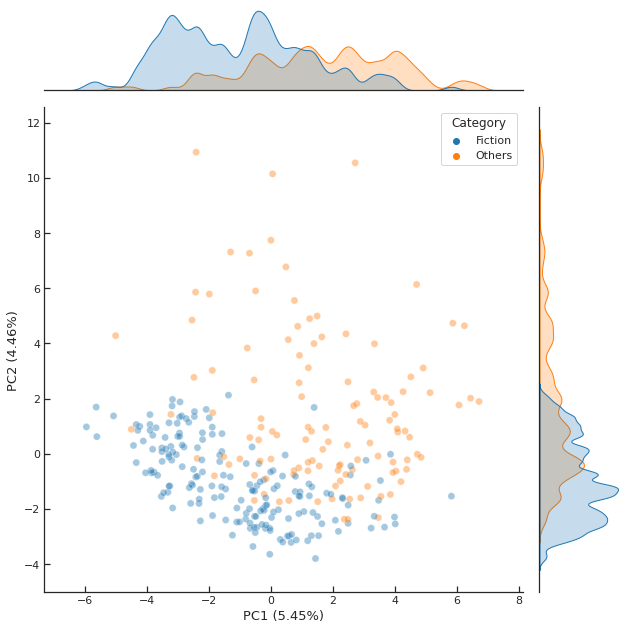

In [ ]:
from sklearn.decomposition import PCA

set_plot_params()

modelSA = PCA(n_components = 2)
data_out = modelSA.fit_transform(X_normalized)


data = pd.DataFrame(list(zip(data_out, y)), columns = ['pca', 'class'])
data[['pca1', 'pca2']] = pd.DataFrame(data.pca.tolist(), index = data.pca.index)
data = data.drop('pca', axis=1)

data.loc[data["class"] == 0, "Category"] = "Fiction"
data.loc[data["class"] == 1, "Category"] = "Others"
    

g = sns.jointplot(data = data, x = data['pca1'], y = data['pca2'], hue = 'Category', 
                  height = 9, marker = 'o', s = 50, alpha = 0.4, legend = True,
                  marginal_kws=dict(bw_method=0.1))
g.set_axis_labels(f'PC1 ({round(modelSA.explained_variance_ratio_[0] * 100, 2)}%)', f'PC2 ({round(modelSA.explained_variance_ratio_[1] * 100, 2)}%)', fontsize=13)

g.ax_joint.tick_params(which='major', direction="in", left=True, bottom=True)

#plt.legend(title='Category', loc='upper left', labels=['Real', 'Meaningless'])
        
# plt.title("d2v PCA [normalized]", size = 11)

#plt.savefig('pcaD2V_normalized.pdf', bbox_inches='tight')
plt.show(g)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import math 


# Root mean square error (rmse)
def calc_separation_score(x, y):
    x = x[0]
    y = y[0]
    
    score = 0
    for i in range(29):
        score += (x[i] - y[i])**2

    score /= 29
    score = math.sqrt(score)
    return round(score, 4)


def rmse(y_actual, y_predicted):
    y_actual = y_actual[0]
    y_predicted = y_predicted[0]
    return round(sqrt(mean_squared_error(y_actual, y_predicted)), 4)

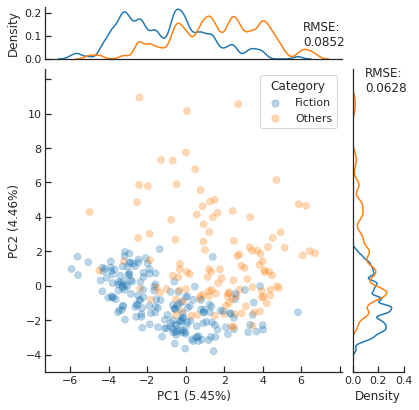

In [ ]:
set_plot_params()

grid = sns.JointGrid(x=data['pca1'], y=data['pca2'], data=data, marginal_ticks=True)

g = grid.plot_joint(sns.scatterplot, hue='Category', data=data, s=50, 
                    alpha=0.3, edgecolor='face')

g.set_axis_labels(f'PC1 ({round(modelSA.explained_variance_ratio_[0] * 100, 2)}%)', 
                  f'PC2 ({round(modelSA.explained_variance_ratio_[1] * 100, 2)}%)')
g.ax_joint.tick_params(which='major', direction="in", left=True, bottom=True)
plt.setp(g.ax_joint.get_yticklabels()[-1], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[-1], visible=False)

leg = g.ax_joint.legend(loc="upper right", scatterpoints=1, title="Category")
for lh in leg.legendHandles: 
    lh.set_alpha(0.3)
    lh.set_sizes([50])
    lh.set_edgecolors('face')

sns.kdeplot(x=data.loc[data['Category']=='Fiction', 'pca1'], ax=g.ax_marg_x, 
        legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(x=data.loc[data['Category']=='Others', 'pca1'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(y=data.loc[data['Category']=='Fiction', 'pca2'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(y=data.loc[data['Category']=='Others', 'pca2'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1)


g.ax_marg_x.set_yticks([0.0, 0.1, 0.2])
g.ax_marg_y.set_xticks([0.0, 0.2, 0.4])

g.ax_marg_x.tick_params(which='major', direction="in", left=True)
g.ax_marg_y.tick_params(which='major', direction="in", bottom=True)

g.ax_marg_x.text(6.1, 0.06, "RMSE:\n" + str(rmse2(data.loc[data['Category']=='Others', 'pca1'], 
                                           data.loc[data['Category']=='Fiction', 'pca1'], 
                                           min(data['pca1'].values), max(data['pca1'].values))))

g.ax_marg_y.text(0.1, 11.29, "RMSE:\n" + str(rmse2(data.loc[data['Category']=='Others', 'pca2'], 
                                           data.loc[data['Category']=='Fiction', 'pca2'], 
                                           min(data['pca2'].values), max(data['pca2'].values))))

g.savefig('pca_d2v.pdf', bbox_inches='tight')
plt.show()

### LDA 

Handling data:

In [ ]:
X = []

for i in range(0, len(fiction_texts) + len(others_texts)):
    X.append(model.dv[i])

X = np.array(X)
y = np.array(documents_df['class'])

Applying 1D LDA SemAxis with L1O cross-validation:

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

modelSA = LinearDiscriminantAnalysis()
data_out, modelSA = validateModel(modelSA, X, y, 0, True)

data = pd.DataFrame(data_out, columns = ["value", "class"])

data.loc[data["class"] == 0, "Category"] = "Fiction"
data.loc[data["class"] == 1, "Category"] = "Others"

data.loc[data["class"] == 1, "class"] = 0.6
data.loc[data["class"] == 0, "class"] = 0.4

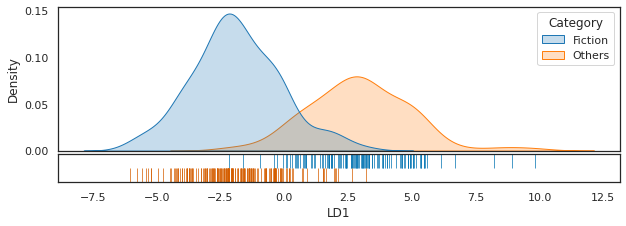

In [ ]:
# ref: https://stackoverflow.com/questions/9879944/adjust-one-subplots-height-in-absolute-way-not-relative-in-matplotlib

import pylab as pl

colors = {'Others': sns.color_palette("colorblind", 11)[10], 
          'Fiction': sns.color_palette("colorblind", 14)[13]}

figure = pl.figure()

#top
ax1 = pl.Axes(figure, [0, 0, 1.3, 0.5])
#ax1.set_yticks([])
#figure.add_axes(ax1) #
sns.kdeplot(data = data, x = data['value'], fill = True, color = custom_palette, 
            hue = 'Category', ax = ax1, legend = True)
ax1.set_xlabel('')
figure.add_axes(ax1) #
#ax1.set_title('d2v LDA [normalized]', size = 11)

#bottom
ax2 = pl.Axes(figure, [0, -0.11, 1.3, .10], sharex = ax1)
figure.add_axes(ax2) 
ax2.scatter(data['value'], data['class'], c = data['Category'].map(colors), 
            marker = '|', s = 200, linewidth=0.7)
ax2.set_ylim(0.3, 0.7)
ax2.set_yticks([])
ax2.set_xlabel('LD1')


plt.setp(ax1.get_xticklabels(), visible = False)

#figure.savefig('ldaD2V_normalized.pdf', bbox_inches='tight')
pl.show()

### SemAxis

Handling data:

In [ ]:
# Handling data
X = []

for i in range(0, len(fiction_texts) + len(others_texts)):
    X.append(model.dv[i])

X = np.array(X)
y = np.array(documents_df['class'])

In [ ]:
import emlens

modelSA = emlens.SemAxis() # load SemAxis Object
data_out, modelSA = validateModel(modelSA, X, y, 1, True)

data = pd.DataFrame(data_out, columns = ["value", "class"])

data.loc[data["class"] == 0, "Category"] = "Fiction"
data.loc[data["class"] == 1, "Category"] = "Others"

data.loc[data["class"] == 1, "class"] = 0.6
data.loc[data["class"] == 0, "class"] = 0.4

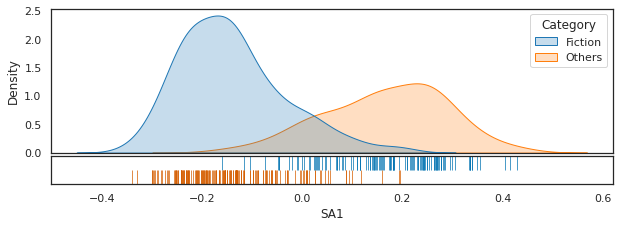

In [ ]:
figure = pl.figure()

#top
ax1 = pl.Axes(figure, [0, 0, 1.3, 0.5])
#ax1.set_yticks([])
figure.add_axes(ax1) #
sns.kdeplot(data = data, x = data['value'], fill = True, color = custom_palette, 
            hue = 'Category', ax = ax1, legend = True)
ax1.set_xlabel('')
#ax1.set_title('d2v SemAxis [normalized]', size = 11)

#bottom
ax2 = pl.Axes(figure, [0, -0.11, 1.3, .10], sharex = ax1)
figure.add_axes(ax2) 
ax2.scatter(data['value'], data['class'], c = data['Category'].map(colors), 
            marker = '|', s = 200, linewidth=0.7)
ax2.set_ylim(0.3, 0.7)
ax2.set_yticks([])
ax2.set_xlabel('SA1')


plt.setp(ax1.get_xticklabels(), visible = False)

#figure.savefig('semaxisD2V_normalized.pdf', bbox_inches='tight')

pl.show()

In [ ]:
import emlens

modelSA = emlens.SemAxis() # load SemAxis Object
data_out, modelSA = validateModel(modelSA, X, y, 1, False)

data = pd.DataFrame(data_out, columns = ["value", "class"])

data.loc[data["class"] == 0, "Category"] = "Fiction"
data.loc[data["class"] == 1, "Category"] = "Others"

data.loc[data["class"] == 1, "class"] = 0.6
data.loc[data["class"] == 0, "class"] = 0.4

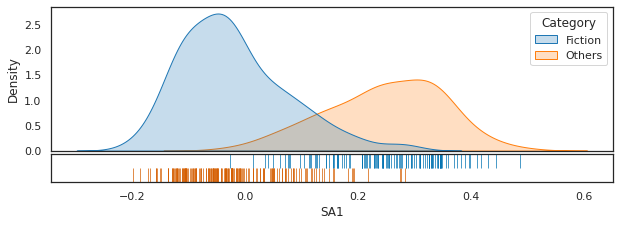

In [ ]:
figure = pl.figure()

#top
ax1 = pl.Axes(figure, [0, 0, 1.3, 0.5])
#ax1.set_yticks([])
figure.add_axes(ax1) #
sns.kdeplot(data = data, x = data['value'], fill = True, color = custom_palette, 
            hue = 'Category', ax = ax1, legend = True)
ax1.set_xlabel('')
#ax1.set_title('d2v SemAxis [normalized]', size = 11)

#bottom
ax2 = pl.Axes(figure, [0, -0.11, 1.3, .10], sharex = ax1)
figure.add_axes(ax2) 
ax2.scatter(data['value'], data['class'], c = data['Category'].map(colors), 
            marker = '|', s = 200, linewidth=0.7)
ax2.set_ylim(0.3, 0.7)
ax2.set_yticks([])
ax2.set_xlabel('SA1')


plt.setp(ax1.get_xticklabels(), visible = False)

#figure.savefig('semaxisD2V_normalized.pdf', bbox_inches='tight')

pl.show()

### UMAP

In [ ]:
# Handling data
X = []

for i in range(0, len(fiction_texts) + len(others_texts)):
    X.append(model.dv[i])

X = np.array(X)
y = np.array(documents_df['class'])

In [ ]:
import umap

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

modelUMAP = umap.UMAP(metric='cosine').fit_transform(X_norm) #standard values

In [ ]:
import sys
import inspect
import scipy.stats

def CountQuads(Arr2D, point):
    """ Computes the probabilities of finding points in each 4 quadrant
    defined by a vertical and horizontal lines crossing the point, by counting
    the proportion of points in Arr2D in each quadrant.
    :param list Arr2D: Array of points to be counted.
    :param array point: A 2 element list, point, which is the center of
    4 square quadrants.
    :returns: a tuple of 4 floats.  The probabilities of finding a point in
    each quadrants, with point as the origin.  p stands for positive, n for
    negative, with the first and second positions meaning the x and y
    directions respectively.
    """
    if isinstance(point, list):
        point = np.asarray((np.ravel(point)))
    elif type(point).__module__+type(point).__name__ == 'numpyndarray':
        point = np.ravel(point.copy())
    else:
        raise TypeError('Input point is neither list nor numpyndarray')
    if len(point) != 2:
        return
    if isinstance(Arr2D, list):
        Arr2D = np.asarray((Arr2D))
    elif type(Arr2D).__module__+type(Arr2D).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D is neither list nor numpyndarray')
    if Arr2D.shape[1] > Arr2D.shape[0]:  # Reshape to A[row,column]
        Arr2D = Arr2D.copy().T
    if Arr2D.shape[1] != 2:
        raise TypeError('Input Arr2D is not 2D')
    # The pp of Qpp refer to p for 'positive' and n for 'negative' quadrants.
    # In order. first subscript is x, second is y.
    Qpp = Arr2D[(Arr2D[:, 0] > point[0]) & (Arr2D[:, 1] > point[1]), :]
    Qnp = Arr2D[(Arr2D[:, 0] < point[0]) & (Arr2D[:, 1] > point[1]), :]
    Qpn = Arr2D[(Arr2D[:, 0] > point[0]) & (Arr2D[:, 1] < point[1]), :]
    Qnn = Arr2D[(Arr2D[:, 0] < point[0]) & (Arr2D[:, 1] < point[1]), :]
    # Normalized fractions:
    ff = 1./len(Arr2D)
    fpp = len(Qpp)*ff
    fnp = len(Qnp)*ff
    fpn = len(Qpn)*ff
    fnn = len(Qnn)*ff
    # NOTE:  all the f's are supposed to sum to 1.0. Float representation
    # cause SOMETIMES sum to 1.000000002 or something. I don't know how to
    # test for that reliably, OR what to do about it yet. Keep in mind.
    return(fpp, fnp, fpn, fnn)


def FuncQuads(func2D, point, xlim, ylim, rounddig=4):
    """ Computes the probabilities of finding points in each 4 quadrant
    defined by a vertical and horizontal lines crossing the point, by
    integrating the density function func2D in each quadrant.
    :param array func2D: Density function that takes 2 arguments: x and y.
    :param list point: A 2 element list, point, which is the center of 4
    square quadrants.
    :param array xlim,ylim: Domain of numerical integration necessary to
    compute the quadrant probabilities.
    :returns: a tuple of 4 floats. The probabilities of finding a point in
    each quadrants, with point as the origin.  p stands for positive,
    n for negative, with the first and second positions meaning the x and y
    directions respectively.
    """
    if callable(func2D):
        if len(inspect.getfullargspec(func2D)[0]) != 2:
            raise TypeError('Input func2D is not a function with 2 arguments')
        pass
    else:
        raise TypeError('Input func2D is not a function')
    # If xlim, ylim and point are not lists or ndarray, exit.
    if isinstance(point, list):
        point = np.asarray((np.ravel(point)))
    elif type(point).__module__+type(point).__name__ == 'numpyndarray':
        point = np.ravel(point.copy())
    else:
        raise TypeError('Input point is not a list or numpyndarray')
    if len(point) != 2:
        raise TypeError('Input point has not exactly 2 elements')
    if isinstance(xlim, list):
        xlim = np.asarray((np.sort(np.ravel(xlim))))
    elif type(xlim).__module__+type(xlim).__name__ == 'numpyndarray':
        xlim = np.sort(np.ravel(xlim.copy()))
    else:
        raise TypeError('Input xlim is not a list or ndarray')
    if len(xlim) != 2:
        raise TypeError('Input xlim has not exactly 2 elements')
    if xlim[0] == xlim[1]:
        raise TypeError('Input xlim[0] should be different to xlim[1]')
    if isinstance(ylim, list):
        ylim = np.asarray((np.sort(np.ravel(ylim))))
    elif type(ylim).__module__+type(ylim).__name__ == 'numpyndarray':
        ylim = np.sort(np.ravel(ylim.copy()))
    else:
        raise TypeError('Input ylim is not a list or ndarray')
    if len(ylim) != 2:
        raise TypeError('Input ylim has not exactly 2 elements')
    if ylim[0] == ylim[1]:
        raise TypeError('Input ylim[0] should be different to ylim[1]')
    # Numerical integration to find the quadrant probabilities.
    totInt = scipy.integrate.dblquad(func2D, *xlim,
                                     lambda x: np.amin(ylim),
                                     lambda x: np.amax(ylim))[0]
    Qpp = scipy.integrate.dblquad(func2D, point[0], np.amax(xlim),
                                  lambda x: point[1],
                                  lambda x: np.amax(ylim))[0]
    Qpn = scipy.integrate.dblquad(func2D, point[0], np.amax(xlim),
                                  lambda x: np.amin(ylim),
                                  lambda x: point[1])[0]
    Qnp = scipy.integrate.dblquad(func2D, np.amin(xlim), point[0],
                                  lambda x: point[1],
                                  lambda x: np.amax(ylim))[0]
    Qnn = scipy.integrate.dblquad(func2D, np.amin(xlim), point[0],
                                  lambda x: np.amin(ylim),
                                  lambda x: point[1])[0]
    fpp = round(Qpp/totInt, rounddig)
    fnp = round(Qnp/totInt, rounddig)
    fpn = round(Qpn/totInt, rounddig)
    fnn = round(Qnn/totInt, rounddig)
    return(fpp, fnp, fpn, fnn)


def Qks(alam, iter=100, prec=1e-17):
    """ Computes the value of the KS probability function, as a function of
    alam, the D statistic. From *Numerical recipes in C* page 623: '[...]
    the K–S statistic useful is that its distribution in the case of the null
    hypothesis (data sets drawn from the same distribution) can be calculated,
    at least to useful approximation, thus giving the significance of any
    observed nonzero value of D.' (D being the KS statistic).
    :param float alam: D statistic.
    :param int iter: Number of iterations to be perfomed. On non-convergence,
    returns 1.0.
    :param float prec: Convergence criteria of the qks. Stops converging if
    that precision is attained.
    :returns: a float. The significance level of the observed D statistic.
    """
    # If j iterations are performed, meaning that toadd
    # is still 2 times larger than the precision.
    if isinstance(alam, int) | isinstance(alam, float):
        pass
    else:
        raise TypeError('Input alam is neither int nor float')
    toadd = [1]
    qks = 0.
    j = 1
    while (j < iter) & (abs(toadd[-1]) > prec*2):
        toadd.append(2.*(-1.)**(j-1.)*np.exp(-2.*j**2.*alam**2.))
        qks += toadd[-1]
        j += 1
    if (j == iter) | (qks > 1):  # If no convergence after j iter, return 1.0
        return(1.0)
    if qks < prec:
        return(0.)
    else:
        return(qks)


def ks2d2s(Arr2D1, Arr2D2):
    """ ks stands for Kolmogorov-Smirnov, 2d for 2 dimensional,
    2s for 2 samples.
    KS test for goodness-of-fit on two 2D samples. Tests the hypothesis that
    the two samples are from the same distribution.
    :param array Arr2D1: 2D array of points/samples.
    :param array Arr2D2: 2D array of points/samples.
    :returns: a tuple of two floats. First, the two-sample K-S statistic.
    If this value is higher than the significance level of the hypothesis,
    it is rejected. Second, the significance level of *d*. Small values of
    prob show that the two samples are significantly different.
    """
    if type(Arr2D1).__module__+type(Arr2D1).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D1 is neither list nor numpyndarray')
    if Arr2D1.shape[1] > Arr2D1.shape[0]:
        Arr2D1 = Arr2D1.copy().T
    if type(Arr2D2).__module__+type(Arr2D2).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D2 is neither list nor numpyndarray')
    if Arr2D2.shape[1] > Arr2D2.shape[0]:
        Arr2D2 = Arr2D2.copy().T
    if Arr2D1.shape[1] != 2:
        raise TypeError('Input Arr2D1 is not 2D')
    if Arr2D2.shape[1] != 2:
        raise TypeError('Input Arr2D2 is not 2D')
    d1, d2 = 0., 0.
    for point1 in Arr2D1:
        fpp1, fmp1, fpm1, fmm1 = CountQuads(Arr2D1, point1)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D2, point1)
        d1 = max(d1, abs(fpp1-fpp2))
        d1 = max(d1, abs(fpm1-fpm2))
        d1 = max(d1, abs(fmp1-fmp2))
        d1 = max(d1, abs(fmm1-fmm2))
    for point2 in Arr2D2:
        fpp1, fmp1, fpm1, fmm1 = CountQuads(Arr2D1, point2)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D2, point2)
        d2 = max(d2, abs(fpp1-fpp2))
        d2 = max(d2, abs(fpm1-fpm2))
        d2 = max(d2, abs(fmp1-fmp2))
        d2 = max(d2, abs(fmm1-fmm2))
    d = (d1+d2)/2.
    sqen = np.sqrt(len(Arr2D1)*len(Arr2D2)/(len(Arr2D1)+len(Arr2D2)))
    R1 = scipy.stats.pearsonr(Arr2D1[:, 0], Arr2D1[:, 1])[0]
    R2 = scipy.stats.pearsonr(Arr2D2[:, 0], Arr2D2[:, 1])[0]
    RR = np.sqrt(1.-(R1*R1+R2*R2)/2.)
    prob = Qks(d*sqen/(1.+RR*(0.25-0.75/sqen)))
    # Small values of prob show that the two samples are significantly
    # different. Prob is the significance level of an observed value of d.
    # NOT the same as the significance level that ou set and compare to D.
    #return(d, prob)
    return round(d, 4)

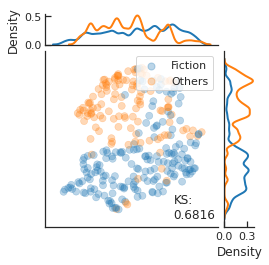

In [ ]:
set_plot_params()

data = pd.DataFrame(list(zip(modelUMAP, y)), columns = ['umap', 'class'])
data[['umap1', 'umap2']] = pd.DataFrame(data.umap.tolist(), index = data.umap.index)
data = data.drop('umap', axis=1)

data.loc[data["class"] == 1, "Category"] = "Others"
data.loc[data["class"] == 0, "Category"] = "Fiction"

grid = sns.JointGrid(x=data['umap1'], y=data['umap2'], data=data, marginal_ticks=True)

g = grid.plot_joint(sns.scatterplot, hue='Category', data=data, s=50, alpha=0.3, edgecolor='face')

leg = g.ax_joint.legend(loc="upper right", scatterpoints=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.3)
    lh.set_sizes([50])
    lh.set_edgecolors('face')

g.ax_joint.tick_params(which='major', direction="in", left=False, bottom=False)
g.ax_joint.set_xlabel('')
g.ax_joint.set_ylabel('')

for ytick in g.ax_joint.get_yticklabels():
    plt.setp(ytick, visible=False)
    
for xtick in g.ax_joint.get_xticklabels():
    plt.setp(xtick, visible=False)

sns.kdeplot(x=data.loc[data['Category']=='Fiction', 'umap1'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(x=data.loc[data['Category']=='Others', 'umap1'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=data.loc[data['Category']=='Fiction', 'umap2'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=data.loc[data['Category']=='Others', 'umap2'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)

g.ax_marg_y.set_xticks([0.0, 0.3])
g.ax_marg_x.tick_params(which='major', direction="in", left=True, labelleft=True)
g.ax_marg_y.tick_params(which='major', direction="in", bottom=True, labelbottom=True)

g.ax_joint.text(8.5, .8, "KS:\n" + 
                str(ks2d2s(np.array(data.loc[data['Category']=='Fiction', ['umap1', 'umap2']]), 
                    np.array(data.loc[data['Category']=='Others', ['umap1', 'umap2']]))))

g.fig.set_size_inches((3.5, 3.5))
g.fig.set_rasterized(True)

plt.savefig('umapD2V_normalized.pdf', bbox_inches='tight', dpi=300)
#plt.show()

___

## Checking ROC-AUC

Ref: [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html)

In [15]:
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

In [25]:
random_state = np.random.RandomState(0)
scaler = StandardScaler()

def get_roc_and_aoc(X, y):
    cv = StratifiedKFold(n_splits=6)
    classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        scaler.fit(X[train])
        X[train] = scaler.transform(X[train])
        X[test] = scaler.transform(X[test])

        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")


    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )


    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label 'Fiction')",
    )

    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

In [26]:
X = []
for i in range(0, len(fiction_texts) + len(others_texts)):
    X.append(model.dv[i])
X = np.array(X)

y = documents_df[['class']]['class'].apply(lambda x: 1 if x in [0] else 0) # transforming fiction in 1 and others in 0

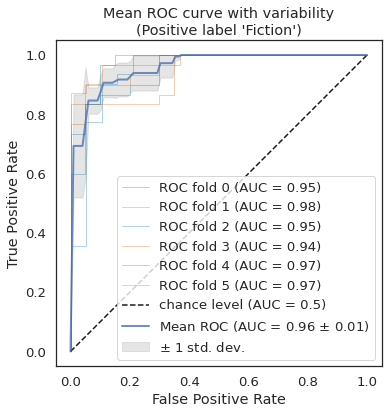

In [27]:
get_roc_and_aoc(X, y)